In [7]:
### This function downloads Google Drive Shared Files By Passing Its Sharing Link And The Desired Destination Path
###
## https://github.com/ndrplz/google-drive-downloader
## download datasets: pip install googledrivedownloader
def download_from_google_drive(id, destPath):
    """This function downloads Google Drive Shared Files By Passing Its Sharing Link And The Desired Destination Path     """
    ## confirm if the file already exists.
    import os.path
    if os.path.isfile(destPath):
        print("The File Already Exists. Please Change The Path Destination.");
        return False;
    # then download the file arguments = (file_id, dest_path, overwrite=False, unzip=False)
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id=id,
                                        dest_path=destPath);
    ## confirm if the file was saved
    if os.path.isfile(destPath):
        print("Success Downloading File.");
        return True;
    else:
        print("The File Couldnt Be Downloaded. Please Confirm If The Parameters Are Correct.");
        return False;
###download_from_google_drive('1fuMxj-dnMXEPHGhHwuQoNjBovO_v5Kdk', './Dataset/adsa.zip');

Success Downloading File.


In [2]:
def extract_features():
    # http://tsfresh.readthedocs.io/en/latest/text/quick_start.html
    from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, \
    load_robot_execution_failures
    download_robot_execution_failures()
    timeseries, y = load_robot_execution_failures()
    timeseries.describe()
    
    from tsfresh import extract_features
    
    extracted_features = extract_features(timeseries, column_id="id", column_sort="time")
    from tsfresh.utilities.dataframe_functions import impute
    from tsfresh import extract_relevant_features
    impute(extracted_features)
    features_filtered = select_features(extracted_features, y)
    features_filtered_direct = extract_relevant_features(timeseries, y,
                                                         column_id='id', column_sort='time')

## Semi-Supervised Learning
### Pseudo-Labelling

In [1]:
### ref: https://www.analyticsvidhya.com/blog/2017/09/pseudo-labelling-semi-supervised-learning-technique/
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder 

In [2]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
#train['Item_Fat_Content'] = train['Item_Fat_Content'].astype(str)
train.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [3]:
# preprocessing

### mean imputations 
train['Item_Weight'].fillna((train['Item_Weight'].mean()), inplace=True)
test['Item_Weight'].fillna((test['Item_Weight'].mean()), inplace=True)

### reducing fat content to only two categories 
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace(['low fat','LF'], 'Low Fat') 
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace(['reg'], 'Regular') 
test['Item_Fat_Content'] = test['Item_Fat_Content'].replace(['low fat','LF'], 'Low Fat') 
test['Item_Fat_Content'] = test['Item_Fat_Content'].replace(['reg'], 'Regular')

## for calculating establishment year
train['Outlet_Establishment_Year'] = 2013 - train['Outlet_Establishment_Year'] 
test['Outlet_Establishment_Year'] = 2013 - test['Outlet_Establishment_Year'] 

### missing values for size
train['Outlet_Size'].fillna('Small',inplace=True)
test['Outlet_Size'].fillna('Small',inplace=True)

### label encoding cate. var.
col = ['Outlet_Size','Outlet_Location_Type','Outlet_Type','Item_Fat_Content']
test['Item_Outlet_Sales'] = 0
combi = train.append(test)
number = LabelEncoder()
for i in col:
    combi[i] = number.fit_transform(combi[i].astype('str'))
    combi[i] = combi[i].astype('int')
train = combi[:train.shape[0]]
test = combi[train.shape[0]:]
test.drop('Item_Outlet_Sales',axis=1,inplace=True)

## removing id variables 
training = train.drop(['Outlet_Identifier','Item_Type','Item_Identifier'],axis=1)
testing = test.drop(['Outlet_Identifier','Item_Type','Item_Identifier'],axis=1)
y_train = training['Item_Outlet_Sales']
training.drop('Item_Outlet_Sales',axis=1,inplace=True)

features = training.columns
target = 'Item_Outlet_Sales'

X_train, X_test = training, testing

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Model exploration

In [4]:
#from xgboost import XGBRegressor
from sklearn.linear_model import BayesianRidge, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
#from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [5]:
model_factory = [
    RandomForestRegressor(),
    #XGBRegressor(nthread=1),
    #MLPRegressor(),
    Ridge(),
    BayesianRidge(),
    ExtraTreesRegressor(),
    ElasticNet(),
    KNeighborsRegressor(),
    GradientBoostingRegressor()
]

for model in model_factory:
    model.seed = 42
    num_folds = 2

    scores = cross_val_score(model, X_train, y_train, cv=num_folds, scoring='neg_mean_squared_error')
    score_description = " %0.2f (+/- %0.2f)" % (np.sqrt(scores.mean()*-1), scores.std() * 2)

    print('{model:25} CV-5 RMSE: {score}'.format(
        model=model.__class__.__name__,
        score=score_description
    ))

RandomForestRegressor     CV-5 RMSE:  1201.84 (+/- 15556.94)
Ridge                     CV-5 RMSE:  1206.16 (+/- 39008.89)
BayesianRidge             CV-5 RMSE:  1206.39 (+/- 37235.78)
ExtraTreesRegressor       CV-5 RMSE:  1230.23 (+/- 83166.17)
ElasticNet                CV-5 RMSE:  1259.31 (+/- 43903.69)
KNeighborsRegressor       CV-5 RMSE:  1258.82 (+/- 22596.96)
GradientBoostingRegressor CV-5 RMSE:  1093.68 (+/- 13528.80)


In [6]:
## normal submission using KNeighborsRegressor
model = KNeighborsRegressor()
model.fit(X_train,y_train)
pred = model.predict(X_test)

## saving file
sub = pd.DataFrame(data = pred, columns=['Item_Outlet_Sales'])
sub['Item_Identifier'] = test['Item_Identifier']
sub['Outlet_Identifier'] = test['Outlet_Identifier']
#sub.to_csv('bigmart-xgb.csv', index='False')

cross_val_score(model, X_train, y_train, cv=2, scoring='neg_mean_squared_error', n_jobs=1)

array([-1595924.23573189, -1573327.27247376])

Xgb gives us the best results. on submission it gives an rmse of 1152.73

In [7]:
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator, RegressorMixin

class PseudoLabeler(BaseEstimator, RegressorMixin):
    '''
    Sci-kit learn wrapper for creating pseudo-lebeled estimators.
    '''
    
    def __init__(self, model, unlabled_data, features, target, sample_rate=0.2, seed=42):
        '''
        @sample_rate - percent of samples used as pseudo-labelled data
                       from the unlabled dataset
        '''
        assert sample_rate <= 1.0, 'Sample_rate should be between 0.0 and 1.0.'
        
        self.sample_rate = sample_rate
        self.seed = seed
        self.model = model
        self.model.seed = seed
        
        self.unlabled_data = unlabled_data
        self.features = features
        self.target = target
        
    def get_params(self, deep=True):
        return {
            "sample_rate": self.sample_rate,
            "seed": self.seed,
            "model": self.model,
            "unlabled_data": self.unlabled_data,
            "features": self.features,
            "target": self.target
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

        
    def fit(self, X, y):
        '''
        Fit the data using pseudo labeling.
        '''

        augemented_train = self.__create_augmented_train(X, y)
        self.model.fit(
            augemented_train[self.features],
            augemented_train[self.target]
        )
        
        return self


    def __create_augmented_train(self, X, y):
        '''
        Create and return the augmented_train set that consists
        of pseudo-labeled and labeled data.
        '''        
        num_of_samples = int(len(self.unlabled_data) * self.sample_rate)
        
        # Train the model and creat the pseudo-labels
        self.model.fit(X, y)
        pseudo_labels = self.model.predict(self.unlabled_data[self.features])
        
        # Add the pseudo-labels to the test set
        pseudo_data = self.unlabled_data.copy(deep=True)
        pseudo_data[self.target] = pseudo_labels
        
        # Take a subset of the test set with pseudo-labels and append in onto
        # the training set
        sampled_pseudo_data = pseudo_data.sample(n=num_of_samples)
        temp_train = pd.concat([X, y], axis=1)
        augemented_train = pd.concat([sampled_pseudo_data, temp_train])

        return shuffle(augemented_train)
        
    def predict(self, X):
        '''
        Returns the predicted values.
        '''
        return self.model.predict(X)
    
    def get_model_name(self):
        return self.model.__class__.__name__

# Pseudo Labeler

In [8]:
model = PseudoLabeler(
    KNeighborsRegressor(),
    test,
    features,
    target,
    sample_rate = 0.3
)

model.fit(X_train, y_train)
pred = model.predict(X_test)
#cross_val_score(model, X_train, y_train, cv=1, scoring='neg_mean_squared_error', n_jobs=8)

In [9]:
sub = pd.DataFrame(data = pred, columns=['Item_Outlet_Sales'])
sub['Item_Identifier'] = test['Item_Identifier']
sub['Outlet_Identifier'] = test['Outlet_Identifier']
sub.to_csv('pseudo-labelling.csv', index='False')

On submission, it gives a rmse score of 1151.38 which is better than our previous xgb submission.

# Comparing xgboost with xgb with pseudo labelling

In [10]:
model_factory = [
    KNeighborsRegressor(),
    
    PseudoLabeler(
        KNeighborsRegressor(),
        test,
        features,
        target,
        sample_rate=0.3
    ),
]

for model in model_factory:
    model.seed = 42
    num_folds = 2
    
    scores = cross_val_score(model, X_train, y_train, cv=num_folds, scoring='neg_mean_squared_error', n_jobs=1)
    score_description = "MSE: %0.4f (+/- %0.4f)" % (np.sqrt(scores.mean()*-1), scores.std() * 2)

    print('{model:25} CV-{num_folds} {score_cv}'.format(
        model=model.__class__.__name__,
        num_folds=num_folds,
        score_cv=score_description
    ))

KNeighborsRegressor       CV-2 MSE: 1258.8192 (+/- 22596.9633)
PseudoLabeler             CV-2 MSE: 1261.9521 (+/- 36190.1446)


# Performance of pseudo-labelling depedendance on sampling rate

In [11]:
sample_rates = np.linspace(0, 1, 10)

def pseudo_label_wrapper(model):
    return PseudoLabeler(model, test, features, target)

# List of all models to test
model_factory = [
    RandomForestRegressor(n_jobs=1),
    KNeighborsRegressor(),
]

# Apply the PseudoLabeler class to each model
model_factory = map(pseudo_label_wrapper, model_factory)

# Train each model with different sample rates
results = {}
num_folds = 2

for model in model_factory:
    model_name = model.get_model_name()
    print('%s' % model_name)

    results[model_name] = list()
    for sample_rate in sample_rates:
        model.sample_rate = sample_rate
        
        # Calculate the CV-3 R2 score and store it
        scores = cross_val_score(model, X_train, y_train, cv=num_folds, scoring='neg_mean_squared_error', n_jobs=1)
        results[model_name].append(np.sqrt(scores.mean()*-1))

RandomForestRegressor
KNeighborsRegressor


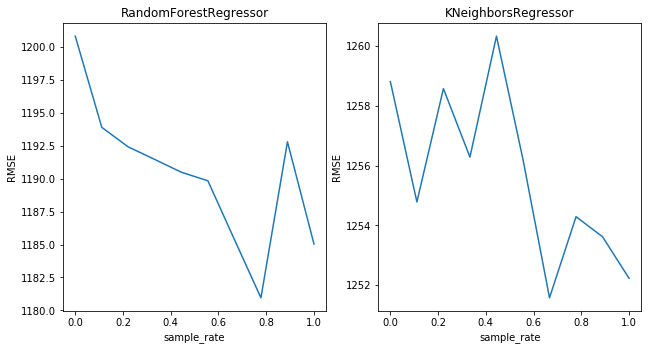

In [12]:
plt.figure(figsize=(16, 18))

i = 1
for model_name, performance in results.items():    
    plt.subplot(3, 3, i)
    i += 1
    
    plt.plot(sample_rates, performance)
    plt.title(model_name)
    plt.xlabel('sample_rate')
    plt.ylabel('RMSE')
    

plt.show()

## Semi-Supervised Learning
### Label Propagation

In [36]:
### ref: http://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelPropagation.html#sklearn.semi_supervised.LabelPropagation
### https://en.wikipedia.org/wiki/Label_Propagation_Algorithm
import numpy as np
from sklearn import datasets
from sklearn.semi_supervised import LabelPropagation
label_prop_model = LabelPropagation()
# load dataset
iris = datasets.load_iris()
rng = np.random.RandomState(42)
random_unlabeled_points = rng.rand(len(iris.target)) < 0.3
labels = np.copy(iris.target)
labels[random_unlabeled_points] = -1
label_prop_model.fit(iris.data, labels)
# predict
Y_Test = np.copy(iris.target)[random_unlabeled_points]
X_Test = iris.data[random_unlabeled_points]
Y_Pred = label_prop_model.predict(X_Test);
# score
score = int(label_prop_model.score(X_Test, Y_Test) * 100)
print("Label Propagation:", score)

Label Propagation: 96


## Semi-Supervised Learning
### Label Spreading

In [38]:
# ref: http://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelSpreading.html#sklearn.semi_supervised.LabelSpreading
# This model is similar to the basic Label Propagation algorithm, 
#   but uses affinity matrix based on the normalized graph Laplacian and soft clamping across the labels
from sklearn import datasets
from sklearn.semi_supervised import LabelSpreading
label_prop_models_spr = LabelSpreading()
# load dataset
iris = datasets.load_iris()
rng = np.random.RandomState(42)
random_unlabeled_points = rng.rand(len(iris.target)) < 0.3
labels = np.copy(iris.target)
# ommit some labels
labels[random_unlabeled_points] = -1
label_prop_models_spr.fit(iris.data, labels)
# predict
Y_Test = np.copy(iris.target)[random_unlabeled_points]
X_Test = iris.data[random_unlabeled_points]
Y_Pred = label_prop_models_spr.predict(X_Test);
# score
score = int(label_prop_models_spr.score(X_Test, Y_Test) * 100)
print("Label Spreading Accuracy:", score)

Label Spreading Accuracy: 96


## Feature Extraction <a class="anchor" id="feature-e"></a>
### Applying Specific Time Window and Feature Extraction Techiques

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
all_values = pd.read_csv("./t1-3_all_values_50ms.csv");

In [3]:
# time series feature extraction techniques
def pearson_correlation(x,y,z):
    from scipy.stats import pearsonr
    # x-y
    pxy =pearsonr(x, y)[0]
    # y-z
    pyz =pearsonr(y, z)[0]
    # x-z
    pxz =pearsonr(x, z)[0]
    return pd.DataFrame([{
        'pxy': float(pxy), 
        'pyz': float(pyz), 
        'pxz': float(pxz)}]);

def signal_mean(x,y,z):
    import numpy as np # linear algebra

    avg_x = np.mean(x.values)
    avg_y = np.mean(y.values)
    avg_z = np.mean(z.values)
    #
    xyz = pd.DataFrame(x);
    xyz = xyz.append(y);
    xyz = xyz.append(z);
    avg_xyz = np.mean(xyz.values)
    #
    return pd.DataFrame([{'avg_x': avg_x, 'avg_y': avg_y, 'avg_z': avg_z, 'avg_xyz': avg_xyz}]);

def signal_std(x,y,z):
    import numpy as np # linear algebra
    std_x = np.std(x.values)
    std_y = np.std(y.values)
    std_z = np.std(z.values)
    #
    return pd.DataFrame([{'std_x': std_x, 'std_y': std_y, 'std_z': std_z}]);
#pearsonr([1,2, 32], [1,2, 7])[0]
#pearson_correlation(pd.DataFrame([1,2,32]),pd.DataFrame([1,2.2,7]),pd.DataFrame([1,2,8]))
#signal_std(pd.DataFrame([1,2]),pd.DataFrame([1,2]),pd.DataFrame([1,2]))
#print(signal_mean(pd.DataFrame([1,2]), pd.DataFrame([0,0]), pd.DataFrame([-1,-2])))

In [4]:
def feature_extraction(array, window, uncertainty):
    from math import fabs
    # acc, gyr, and mag
    # mean
    mean_acc = pd.DataFrame({'avg_value':[]})
    
    mean_accX = pd.DataFrame({'value':[]})
    mean_accY = pd.DataFrame({'value':[]})
    mean_accZ = pd.DataFrame({'value':[]})
    mean_accXYZ = pd.DataFrame({'value':[]})

    mean_gyrX = pd.DataFrame({'value':[]})
    mean_gyrY = pd.DataFrame({'value':[]})
    mean_gyrZ = pd.DataFrame({'value':[]})
    mean_gyrXYZ = pd.DataFrame({'value':[]})
    
    mean_magX = pd.DataFrame({'value':[]})
    mean_magY = pd.DataFrame({'value':[]})
    mean_magZ = pd.DataFrame({'value':[]})
    mean_magXYZ = pd.DataFrame({'value':[]})
    # std
    std_accX = pd.DataFrame({'value':[]})
    std_accY = pd.DataFrame({'value':[]})
    std_accZ = pd.DataFrame({'value':[]})
    
    std_gyrX = pd.DataFrame({'value':[]})
    std_gyrY = pd.DataFrame({'value':[]})
    std_gyrZ = pd.DataFrame({'value':[]})
    
    std_magX = pd.DataFrame({'value':[]})
    std_magY = pd.DataFrame({'value':[]})
    std_magZ = pd.DataFrame({'value':[]})
    
    # pearson_correlation
    pea_accXY = pd.DataFrame({'value':[]})
    pea_accYZ = pd.DataFrame({'value':[]})
    pea_accXZ = pd.DataFrame({'value':[]})
    
    pea_gyrXY = pd.DataFrame({'value':[]})
    pea_gyrYZ = pd.DataFrame({'value':[]})
    pea_gyrXZ = pd.DataFrame({'value':[]})
    
    pea_magXY = pd.DataFrame({'value':[]})
    pea_magYZ = pd.DataFrame({'value':[]})
    pea_magXZ = pd.DataFrame({'value':[]})

    # global variables
    old_ts = array.iloc[0]['Fts(ms)'];
    i = 0;
    values = []
    values_accX = []
    values_accY = []
    values_accZ = []

    values_gyrX = []
    values_gyrY = []
    values_gyrZ = []

    values_magX = []
    values_magY = []
    values_magZ = []
    for index, line in array.iterrows():
        ts = line['Fts(ms)']       
        accX = line['accX']
        accY = line['accY']
        accZ = line['accZ']

        magX = line['magX']
        magY = line['magY']
        magZ = line['magZ']

        gyrX = line['gyrX']
        gyrY = line['gyrY']
        gyrZ = line['gyrZ']
        
        diff = ts - old_ts;
        # add values  values += [ts]
        values += [ts]
        values_accX += [accX]
        values_accY += [accY]
        values_accZ += [accZ]
        
        values_gyrX += [gyrX]
        values_gyrY += [gyrY]
        values_gyrZ += [gyrZ]
        
        values_magX += [magX]
        values_magY += [magY]
        values_magZ += [magZ]
        #
        
        if diff == window or fabs(diff - window) <= uncertainty:
            i+=1
            old_ts = ts
            #### feature extraction 
            # mean
            out_mean_acc = signal_mean(pd.DataFrame(values_accX), 
                                       pd.DataFrame(values_accY),
                                       pd.DataFrame(values_accZ));
            out_mean_gyr = signal_mean(pd.DataFrame(values_gyrX), 
                                       pd.DataFrame(values_gyrY),
                                       pd.DataFrame(values_gyrZ));
            out_mean_mag = signal_mean(pd.DataFrame(values_magX), 
                                       pd.DataFrame(values_magY),
                                       pd.DataFrame(values_magZ));
            # std 
            out_std_acc = signal_std(pd.DataFrame(values_accX), 
                                       pd.DataFrame(values_accY),
                                       pd.DataFrame(values_accZ));
            out_std_gyr = signal_std(pd.DataFrame(values_gyrX), 
                                       pd.DataFrame(values_gyrY),
                                       pd.DataFrame(values_gyrZ));
            out_std_mag = signal_std(pd.DataFrame(values_magX), 
                                       pd.DataFrame(values_magY),
                                       pd.DataFrame(values_magZ));

            # corre
            out_pea_acc = pearson_correlation(pd.DataFrame(values_accX), 
                                       pd.DataFrame(values_accY),
                                       pd.DataFrame(values_accZ));
            out_pea_gyr = pearson_correlation(pd.DataFrame(values_gyrX), 
                                       pd.DataFrame(values_gyrY),
                                       pd.DataFrame(values_gyrZ));
            out_pea_mag = pearson_correlation(pd.DataFrame(values_magX), 
                                       pd.DataFrame(values_magY),
                                       pd.DataFrame(values_magZ));
            ####
            # pd.DataFrame([{'avg_x': avg_x, 'avg_y': avg_y, 'avg_z': avg_z, 'avg_xyz': avg_xyz}]);
            # mean
            mean_accX = mean_accX.append(pd.DataFrame({
                'value':[out_mean_acc['avg_x'][0]]}))
            mean_accY = mean_accY.append(pd.DataFrame({
                'value':[out_mean_acc['avg_y'][0]]}))
            mean_accZ = mean_accZ.append(pd.DataFrame({
                'value':[out_mean_acc['avg_z'][0]]}))
            mean_accXYZ = mean_accXYZ.append(pd.DataFrame({
                'value':[out_mean_acc['avg_xyz'][0]]}))
             
            mean_gyrX = mean_gyrX.append(pd.DataFrame({
                'value':[out_mean_gyr['avg_x'][0]]}))
            mean_gyrY = mean_gyrY.append(pd.DataFrame({
                'value':[out_mean_gyr['avg_y'][0]]}))
            mean_gyrZ = mean_gyrZ.append(pd.DataFrame({
                'value':[out_mean_gyr['avg_z'][0]]}))
            mean_gyrXYZ = mean_gyrXYZ.append(pd.DataFrame({
                'value':[out_mean_gyr['avg_xyz'][0]]}))
            
            mean_magX = mean_magX.append(pd.DataFrame({
                'value':[out_mean_mag['avg_x'][0]]}))
            mean_magY = mean_magY.append(pd.DataFrame({
                'value':[out_mean_mag['avg_y'][0]]}))
            mean_magZ = mean_magZ.append(pd.DataFrame({
                'value':[out_mean_mag['avg_z'][0]]}))
            mean_magXYZ = mean_magXYZ.append(pd.DataFrame({
                'value':[out_mean_mag['avg_xyz'][0]]}))
          
            # std  return pd.DataFrame([{'std_x': std_x, 'std_y': std_y, 'std_z': std_z}]);
            std_accX = std_accX.append(pd.DataFrame({
                'value':[out_std_acc['std_x'][0]]}))
            std_accY = std_accY.append(pd.DataFrame({
                'value':[out_std_acc['std_y'][0]]}))
            std_accZ = std_accZ.append(pd.DataFrame({
                'value':[out_std_acc['std_z'][0]]}))

            std_gyrX = std_gyrX.append(pd.DataFrame({
                'value':[out_std_gyr['std_x'][0]]}))
            std_gyrY = std_gyrY.append(pd.DataFrame({
                'value':[out_std_gyr['std_y'][0]]}))
            std_gyrZ = std_gyrZ.append(pd.DataFrame({
                'value':[out_std_gyr['std_z'][0]]}))

            std_magX = std_magX.append(pd.DataFrame({
                'value':[out_std_mag['std_x'][0]]}))
            std_magY = std_magY.append(pd.DataFrame({
                'value':[out_std_mag['std_y'][0]]}))
            std_magZ = std_magZ.append(pd.DataFrame({
                'value':[out_std_mag['std_z'][0]]}))
    
            # corr return pd.DataFrame([{'pxy': pxy, 'pyz':pyz, 'pxz':pxz}]);
            pea_accXY = pea_accXY.append(pd.DataFrame({
                'value':[out_pea_acc['pxy'][0]]}))
            pea_accYZ = pea_accYZ.append(pd.DataFrame({
                'value':[out_pea_acc['pyz'][0]]}))
            pea_accXZ = pea_accXZ.append(pd.DataFrame({
                'value':[out_pea_acc['pxz'][0]]}))
            
            pea_gyrXY = pea_gyrXY.append(pd.DataFrame({
                'value':[out_pea_gyr['pxy'][0]]}))
            pea_gyrYZ = pea_gyrYZ.append(pd.DataFrame({
                'value':[out_pea_gyr['pyz'][0]]}))
            pea_gyrXZ = pea_gyrXZ.append(pd.DataFrame({
                'value':[out_pea_gyr['pxz'][0]]}))
            
            pea_magXY = pea_magXY.append(pd.DataFrame({
                'value':[out_pea_mag['pxy'][0]]}))
            pea_magYZ = pea_magYZ.append(pd.DataFrame({
                'value':[out_pea_mag['pyz'][0]]}))
            pea_magXZ = pea_magXZ.append(pd.DataFrame({
                'value':[out_pea_mag['pxz'][0]]}))
            
    
            # set values  values = [old_ts]
            values = [old_ts]
            values_accX = [accX]
            values_accY = [accY]
            values_accZ = [accZ]
            values_gyrX = [gyrX]
            values_gyrY = [gyrY]
            values_gyrZ = [gyrZ]
            values_magX = [magX]
            values_magY = [magY]
            values_magZ = [magZ]
            continue
        elif diff > window or old_ts == -1:
            old_ts = ts
            # set values values = [old_ts]
            values = [old_ts]
            values_accX = [accX]
            values_accY = [accY]
            values_accZ = [accZ]
            values_gyrX = [gyrX]
            values_gyrY = [gyrY]
            values_gyrZ = [gyrZ]
            values_magX = [magX]
            values_magY = [magY]
            values_magZ = [magZ]
        
        # mean       
        mean_accX = mean_accX.append(pd.DataFrame({'value':[None]}))
        mean_accY = mean_accY.append(pd.DataFrame({'value':[None]}))
        mean_accZ = mean_accZ.append(pd.DataFrame({'value':[None]}))
        mean_accXYZ = mean_accXYZ.append(pd.DataFrame({'value':[None]}))
        
        mean_gyrX = mean_gyrX.append(pd.DataFrame({'value':[None]}))
        mean_gyrY = mean_gyrY.append(pd.DataFrame({'value':[None]}))
        mean_gyrZ = mean_gyrZ.append(pd.DataFrame({'value':[None]}))
        mean_gyrXYZ = mean_gyrXYZ.append(pd.DataFrame({'value':[None]}))
        
        mean_magX = mean_magX.append(pd.DataFrame({'value':[None]}))
        mean_magY = mean_magY.append(pd.DataFrame({'value':[None]}))
        mean_magZ = mean_magZ.append(pd.DataFrame({'value':[None]}))
        mean_magXYZ = mean_magXYZ.append(pd.DataFrame({'value':[None]}))
      
        # std  return pd.DataFrame([{'std_x': std_x, 'std_y': std_y, 'std_z': std_z}]);
        std_accX = std_accX.append(pd.DataFrame({'value':[None]}))
        std_accY = std_accY.append(pd.DataFrame({'value':[None]}))
        std_accZ = std_accZ.append(pd.DataFrame({'value':[None]}))
        
        std_gyrX = std_gyrX.append(pd.DataFrame({
            'value':[None]}))
        std_gyrY = std_gyrY.append(pd.DataFrame({
            'value':[None]}))
        std_gyrZ = std_gyrZ.append(pd.DataFrame({
            'value':[None]}))

        std_magX = std_magX.append(pd.DataFrame({
            'value':[None]}))
        std_magY = std_magY.append(pd.DataFrame({
            'value':[None]}))
        std_magZ = std_magZ.append(pd.DataFrame({
            'value':[None]}))
    
        # corr return pd.DataFrame([{'pxy': pxy, 'pyz':pyz, 'pxz':pxz}]);
        pea_accXY = pea_accXY.append(pd.DataFrame({
            'value':[None]}))
        pea_accYZ = pea_accYZ.append(pd.DataFrame({
            'value':[None]}))
        pea_accXZ = pea_accXZ.append(pd.DataFrame({
            'value':[None]}))

        pea_gyrXY = pea_gyrXY.append(pd.DataFrame({
            'value':[None]}))
        pea_gyrYZ = pea_gyrYZ.append(pd.DataFrame({
            'value':[None]}))
        pea_gyrXZ = pea_gyrXZ.append(pd.DataFrame({
            'value':[None]}))

        pea_magXY = pea_magXY.append(pd.DataFrame({
            'value':[None]}))
        pea_magYZ = pea_magYZ.append(pd.DataFrame({
            'value':[None]}))
        pea_magXZ = pea_magXZ.append(pd.DataFrame({
            'value':[None]}))
        
    return pd.DataFrame([{
        # mean
            'mean_accX': mean_accX.values,
            'mean_accY' : mean_accY.values,
            'mean_accZ' : mean_accZ.values, 
            'mean_accXYZ' : mean_accXYZ.values,
        
            'mean_gyrX': mean_gyrX.values,
            'mean_gyrY' : mean_gyrY.values,
            'mean_gyrZ' : mean_gyrZ.values, 
            'mean_gyrXYZ' : mean_gyrXYZ.values,
        
            'mean_magX': mean_magX.values,
            'mean_magY' : mean_magY.values,
            'mean_magZ' : mean_magZ.values, 
            'mean_magXYZ' : mean_magXYZ.values,
        
        # std
            'std_accX' : std_accX.values, 
            'std_accY' : std_accY.values, 
            'std_accZ' : std_accZ.values, 

            'std_gyrX' : std_gyrX.values,
            'std_gyrY' : std_gyrY.values,
            'std_gyrZ' : std_gyrZ.values,

            'std_magX' : std_magX.values,
            'std_magY' : std_magY.values,
            'std_magZ' : std_magZ.values,

            # pearson_correlation
            'pea_accXY' : pea_accXY.values,
            'pea_accYZ' : pea_accYZ.values,
            'pea_accXZ' : pea_accXZ.values,

            'pea_gyrXY' : pea_gyrXY.values,
            'pea_gyrYZ' : pea_gyrYZ.values,
            'pea_gyrXZ' : pea_gyrXZ.values,

            'pea_magXY' : pea_magXY.values,
            'pea_magYZ' : pea_magYZ.values,
            'pea_magXZ' : pea_magXZ.values,
        
    }]);
        #print(signal_std(array['accX'], array['accY'], array['accZ']))

In [5]:
# starting feature extraction
#def feature_extraction(all_values):
all_values_with_fe = pd.DataFrame()
users = list(set(all_values['userID']));
users.sort()
time_window_ms = 1000;
time_window_unc_ms = 200;
# users
for line in users:
    subject = all_values[all_values['userID'].isin([line])]
    #experiments
    experiments = list(set(subject['experiment']))
    print(line)
    for lineExp in experiments:     
        subject_exp = subject[subject['experiment'].isin([lineExp])]    
        #positions
        positions = list(set(subject_exp['position']))
        for linePos in positions:
            subject_exp_pos = subject_exp[subject_exp['position'].isin([linePos])]
            subject_pos_label = subject_exp_pos.sort_values(['Fts(ms)'])
            # 200ms sliding window
            fe_signals = feature_extraction(subject_pos_label, time_window_ms, time_window_unc_ms);
            #
            # mean
            mean_accX = pd.DataFrame(fe_signals['mean_accX'][0])
            mean_accY = pd.DataFrame(fe_signals['mean_accY'][0])
            mean_accZ = pd.DataFrame(fe_signals['mean_accZ'][0])
            mean_accXYZ = pd.DataFrame(fe_signals['mean_accXYZ'][0])

            mean_gyrX = pd.DataFrame(fe_signals['mean_gyrX'][0])
            mean_gyrY = pd.DataFrame(fe_signals['mean_gyrY'][0])
            mean_gyrZ = pd.DataFrame(fe_signals['mean_gyrZ'][0])
            mean_gyrXYZ = pd.DataFrame(fe_signals['mean_gyrXYZ'][0])

            mean_magX = pd.DataFrame(fe_signals['mean_magX'][0])
            mean_magY = pd.DataFrame(fe_signals['mean_magY'][0])
            mean_magZ = pd.DataFrame(fe_signals['mean_magZ'][0])
            mean_magXYZ = pd.DataFrame(fe_signals['mean_magXYZ'][0])

            # std
            std_accX = pd.DataFrame(fe_signals['std_accX'][0])
            std_accY = pd.DataFrame(fe_signals['std_accY'][0])
            std_accZ = pd.DataFrame(fe_signals['std_accZ'][0])

            std_gyrX = pd.DataFrame(fe_signals['std_gyrX'][0])
            std_gyrY = pd.DataFrame(fe_signals['std_gyrY'][0])
            std_gyrZ = pd.DataFrame(fe_signals['std_gyrZ'][0])

            std_magX = pd.DataFrame(fe_signals['std_magX'][0])
            std_magY = pd.DataFrame(fe_signals['std_magY'][0])
            std_magZ = pd.DataFrame(fe_signals['std_magZ'][0])


            # pea
            pea_accXY = pd.DataFrame(fe_signals['pea_accXY'][0])
            pea_accYZ = pd.DataFrame(fe_signals['pea_accYZ'][0])
            pea_accXZ = pd.DataFrame(fe_signals['pea_accXZ'][0])

            pea_gyrXY = pd.DataFrame(fe_signals['pea_gyrXY'][0])
            pea_gyrYZ = pd.DataFrame(fe_signals['pea_gyrYZ'][0])
            pea_gyrXZ = pd.DataFrame(fe_signals['pea_gyrXZ'][0])

            pea_magXY = pd.DataFrame(fe_signals['pea_magXY'][0])
            pea_magYZ = pd.DataFrame(fe_signals['pea_magYZ'][0])
            pea_magXZ = pd.DataFrame(fe_signals['pea_magXZ'][0])


            # assign
            subject_pos_label['mean_accX'] = mean_accX.values;
            subject_pos_label['mean_accY'] = mean_accY.values;
            subject_pos_label['mean_accZ'] = mean_accZ.values;
            subject_pos_label['mean_accXYZ'] = mean_accXYZ.values;

            subject_pos_label['mean_gyrX'] = mean_gyrX.values;
            subject_pos_label['mean_gyrY'] = mean_gyrY.values;
            subject_pos_label['mean_gyrZ'] = mean_gyrZ.values;
            subject_pos_label['mean_gyrXYZ'] = mean_gyrXYZ.values;

            subject_pos_label['mean_magX'] = mean_magX.values;
            subject_pos_label['mean_magY'] = mean_magY.values;
            subject_pos_label['mean_magZ'] = mean_magZ.values;
            subject_pos_label['mean_magXYZ'] = mean_magXYZ.values;

            # std
            subject_pos_label['std_accX'] = std_accX.values;
            subject_pos_label['std_accY'] = std_accY.values;
            subject_pos_label['std_accZ'] = std_accZ.values;

            subject_pos_label['std_gyrX'] = std_gyrX.values;
            subject_pos_label['std_gyrY'] = std_gyrY.values;
            subject_pos_label['std_gyrZ'] = std_gyrZ.values;

            subject_pos_label['std_magX'] = std_magX.values;
            subject_pos_label['std_magY'] = std_magY.values;
            subject_pos_label['std_magZ'] = std_magZ.values;

            # pea
            subject_pos_label['pea_accXY'] = pea_accXY.values;
            subject_pos_label['pea_accYZ'] = pea_accYZ.values;
            subject_pos_label['pea_accXZ'] = pea_accXZ.values;

            subject_pos_label['pea_gyrXY'] = pea_gyrXY.values;
            subject_pos_label['pea_gyrYZ'] = pea_gyrYZ.values;
            subject_pos_label['pea_gyrXZ'] = pea_gyrXZ.values;

            subject_pos_label['pea_magXY'] = pea_magXY.values;
            subject_pos_label['pea_magYZ'] = pea_magYZ.values;
            subject_pos_label['pea_magXZ'] = pea_magXZ.values;
            all_values_with_fe = all_values_with_fe.append(subject_pos_label);
            
print(len(all_values_with_fe))
all_values_with_fe_clean = all_values_with_fe[np.isfinite(all_values_with_fe['mean_accX'])]
print(len(all_values_with_fe_clean))
all_values_with_fe_clean.to_csv("t1-4-all_values_with_fe_" + str(time_window_ms) + "ms.csv", sep=',')

Subject 01
Subject 02
Subject 03
Subject 04
Subject 05
Subject 06
Subject 07


/home/arrayindexoutofbondsexception/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3013: RuntimeWarning: invalid value encountered in true_divide
  prob = _betai(0.5*df, 0.5, df/(df+t_squared))
/home/arrayindexoutofbondsexception/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in true_divide
  r = r_num / r_den


Subject 08
Subject 09
Subject 10
Subject 11
Subject 12
Subject 13
Subject 14
Subject 15
Subject 16
Subject 17
175375
12915
